<a href="https://colab.research.google.com/github/Ouasfi/kelletal2018/blob/master/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import h5py 
import numpy as np
import tensorflow as tf
import os
from PIL import Image

In [0]:
import IPython.display as ipd
import sys

sys.path.append('./network/')
import tensorflow as tf
import scipy.io.wavfile as wav
import matplotlib as plt 

%pylab inline

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/kelletal2018/network

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/kelletal2018/network


In [0]:
class  conv_layer(tf.keras.layers.Layer):
  def __init__(self,layer_params, layer_vars,  *args, **kwargs):
    super( conv_layer, self).__init__(*args, **kwargs)
    self.layer_params = layer_params


  #def build(self, layer_vars):
    self.w = tf.Variable(layer_vars['W'], trainable=True)
    self.b = tf.Variable(layer_vars['b'], trainable= True)
  # Call method will sometimes get used in graph mode,
  # training will get turned into a tensor
  @tf.function
  def call(self, previous_h):
    
    x = tf.nn.conv2d( previous_h, self.w, 
                                  strides=[1,self.layer_params['stride'], self.layer_params['stride'],1],
                              padding='SAME' ) + self.b
    x = tf.nn.relu(x)
    return x 

In [0]:
class  lrnorm_layer(tf.keras.layers.Layer):
  def __init__(self,layer_params,rnorm_bias ,rnorm_alpha , rnorm_beta, **kwargs ):
    super( lrnorm_layer, self).__init__( **kwargs)
    self.depth_radius = layer_params['radius']
    self.rnorm_bias = rnorm_bias
    self.rnorm_alpha = rnorm_alpha
    self.rnorm_beta = rnorm_beta
  
  @tf.function
  def call(self, previous_h):
    
    x = tf.nn.local_response_normalization(previous_h,
                                                     depth_radius = self.depth_radius,
                                                     bias = self.rnorm_bias,
                                                     alpha = self.rnorm_alpha,
                                                     beta = self.rnorm_beta )
    
    return x 

In [0]:

class  pool_layer(tf.keras.layers.Layer):
  def __init__(self,layer_params, max_pool = True,**kwargs ):
    super( pool_layer, self).__init__(**kwargs)
    self.layer_params = layer_params
    self.max_pool = max_pool
  
  @tf.function
  def call(self, previous_h):
    
    if self.max_pool: 
            return tf.nn.max_pool(  previous_h,
                                    ksize=[1,int(self.layer_params['edge']),int(self.layer_params['edge']),1],
                                    strides=[1,int(self.layer_params['stride']),int(self.layer_params['stride']),1],
                                    padding='SAME' )
        
                            
    elif not self.max_pool:
        return tf.nn.avg_pool(  previous_h, 
                                ksize=[1, self.layer_params['edge'],self.layer_params['edge'],1],
                                strides=[1, self.layer_params['stride'], self.layer_params['stride'],1],
                                padding='SAME' )
    return x 

In [0]:
class  flatten_pool_layer(tf.keras.layers.Layer):
  def __init__(self,output_size, *args,**kwargs ):
    super( flatten_pool_layer, self).__init__(*args, **kwargs)
    
    self.output_size = output_size
  
  @tf.function
  def call(self, previous_h):
    x = tf.reshape(previous_h, [-1, self.output_size])
    return x 


In [0]:
class  linear_pool_layer(tf.keras.layers.Layer):
  def __init__(self,layer_vars_dict, branch, *args,**kwargs ):
    super( linear_pool_layer, self).__init__(*args, **kwargs)
    
    self.fc6_W = tf.Variable(layer_vars_dict['fc6_'+ branch]['W'], trainable=True)
    self.fc6_b = tf.Variable(layer_vars_dict['fc6_' + branch ]['b'], trainable= True)
    self.fctop_W = tf.Variable(layer_vars_dict['fctop_' + branch]['W'], trainable=True)
    self.fctop_b = tf.Variable(layer_vars_dict['fctop_' + branch]['b'], trainable=True)

  
  @tf.function
  def call(self, previous_h):
    x = tf.matmul(previous_h, self.fc6_W) + self.fc6_b 
    x = tf.nn.relu(x)
    x = tf.matmul(x,  self.fctop_W) + self.fctop_b

    return x 

In [0]:
class reshape_layer(tf.keras.layers.Layer):
  def __init__(self,layer_params, *args,**kwargs ):
    super( reshape_layer, self).__init__(*args, **kwargs)
    
    self.size = layer_params['edge']
  
  @tf.function
  def call(self, previous_h):
    x= tf.reshape(previous_h, [-1,self.size, self.size,1])
    return x 

In [0]:
rnorm_bias, rnorm_alpha, rnorm_beta = 1., 1e-3, 0.75
lrnorm = lambda s : lrnorm_layer(s, rnorm_bias = rnorm_bias, rnorm_alpha = rnorm_alpha, rnorm_beta =rnorm_beta )

In [0]:
n_out_pool5_W = 6 * 6 * 512 
n_out_pool5_G = 6 * 6 * 512

In [0]:
class branched_network(tf.keras.Model):

  def __init__(self, weights = None):
    super(branched_network, self).__init__()

    self.layer_params_dict = {
                'data':{'edge': 256},
                'conv1': {'edge': 9, 'stride': 3, 'n_filters': 96},
                'rnorm1': {'radius': 2}, 
                'pool1': {'edge': 3, 'stride': 2},
                'conv2': {'edge': 5, 'stride': 2, 'n_filters': 256},
                'rnorm2': {'radius': 2}, 
                'pool2': {'edge': 3, 'stride': 2},
                'conv3': {'edge': 3, 'stride': 1, 'n_filters': 512},
                'conv4_W': {'edge': 3, 'stride': 1, 'n_filters': 1024},
                'conv4_G': {'edge': 3, 'stride': 1, 'n_filters': 1024},
                'conv5_W': {'edge': 3, 'stride': 1, 'n_filters': 512},
                'conv5_G': {'edge': 3, 'stride': 1, 'n_filters': 512},
                'pool5_W': {'edge': 3, 'stride': 2},
                'pool5_G': {'edge': 3, 'stride': 2},
                'fc6_W': {'n_units': 1024},
                'fc6_G': {'n_units': 1024},
                'fctop_W': {'n_units': 589},
                'fctop_G': {'n_units': 43}
        }
    self.load_weights() if weights is None else self.set_weights(weights)
    
    self.commun =  [
        tf.keras.layers.InputLayer(input_shape=(self.layer_params_dict['data']['edge']*self.layer_params_dict['data']['edge'])),
        reshape_layer( self.layer_params_dict['data']),                                
        conv_layer( self.layer_params_dict['conv1'], self.layer_vars_dict['conv1']),
        lrnorm(self.layer_params_dict['rnorm1']),
        pool_layer( self.layer_params_dict['pool1']),
        conv_layer(self.layer_params_dict['conv2'], self.layer_vars_dict['conv2']),
        lrnorm( self.layer_params_dict['rnorm2']),
        pool_layer( self.layer_params_dict['pool2']),
        conv_layer(self.layer_params_dict['conv3'], self.layer_vars_dict['conv3'])
      ]
    self.speech  = [ 
      conv_layer(self.layer_params_dict['conv4_W'], self.layer_vars_dict['conv4_W']),
      conv_layer(self.layer_params_dict['conv5_W'],  self.layer_vars_dict['conv5_W']),
      pool_layer( self.layer_params_dict['pool5_W'],  False),
      flatten_pool_layer(  output_size = n_out_pool5_W ),
      linear_pool_layer(self.layer_vars_dict, branch = "W")
        
      ]
    self.music  = [ 
      conv_layer(self.layer_params_dict['conv4_G'], self.layer_vars_dict['conv4_G']),
      conv_layer(self.layer_params_dict['conv5_G'],  self.layer_vars_dict['conv5_G']),
      pool_layer( self.layer_params_dict['pool5_G'],  False),
      flatten_pool_layer(  output_size = n_out_pool5_G),
      linear_pool_layer(self.layer_vars_dict, branch = "G")
    ]

  def load_weights(self):

    weights_biases = np.load('./weights/network_weights_early_layers.npy', encoding = 'latin1', allow_pickle=True)[()]
    genre_branch =  np.load('./weights/network_weights_genre_branch.npy',  encoding = 'latin1', allow_pickle=True)[()]
    word_branch = np.load('./weights/network_weights_word_branch.npy',  encoding = 'latin1', allow_pickle=True)[()] 
    weights_biases.update(genre_branch)
    weights_biases.update(word_branch)
    self.layer_vars_dict = weights_biases

  def set_weights(self, weights):
    self.layer_vars_dict = weights

  def call(self, x, type):

    for layer in self.commun : x = layer(x)
    if type == "speech":
      for layer in self.speech: x = layer(x)
    if type == "music":
      for layer in self.music: x = layer(x)

    return x

In [1]:
#!git clone https://github.com/mcdermottLab/pycochleagram


Cloning into 'pycochleagram'...
remote: Enumerating objects: 468, done.
remote: Total 468 (delta 0), reused 0 (delta 0), pack-reused 468
Receiving objects: 100% (468/468), 4.62 MiB | 24.25 MiB/s, done.
Resolving deltas: 100% (241/241), done.


In [2]:
#cd pycochleagram


/content/pycochleagram


In [0]:
#!python setup.py install


In [0]:
from pycochleagram import cochleagram as cgram 

In [0]:
## Some helper functions
def resample(example, new_size):
    im = Image.fromarray(example)
    resized_image = im.resize(new_size, resample=Image.ANTIALIAS)
    return np.array(resized_image)

def plot_cochleagram(cochleagram, title): 
    plt.figure(figsize=(6,3))
    plt.matshow(cochleagram.reshape(256,256), origin='lower',cmap=plt.cm.Blues, fignum=False, aspect='auto')
    plt.yticks([]); plt.xticks([]); plt.title(title); 
    
def play_wav(wav_f, sr, title):   
    print( title+':')
    ipd.display(ipd.Audio(wav_f, rate=sr))

In [0]:
def generate_cochleagram(wav_f, sr, title):
    # define parameters
    n, sampling_rate = 50, 16000
    low_lim, hi_lim = 20, 8000
    sample_factor, pad_factor, downsample = 4, 2, 200
    nonlinearity, fft_mode, ret_mode = 'power', 'auto', 'envs'
    strict = True

    # create cochleagram
    c_gram = cgram.cochleagram(wav_f, sr, n, low_lim, hi_lim, 
                               sample_factor, pad_factor, downsample,
                               nonlinearity, fft_mode, ret_mode, strict)
    
    # rescale to [0,255]
    c_gram_rescaled =  255*(1-((np.max(c_gram)-c_gram)/np.ptp(c_gram)))
    
    # reshape to (256,256)
    c_gram_reshape_1 = np.reshape(c_gram_rescaled, (211,400))
    c_gram_reshape_2 = resample(c_gram_reshape_1,(256,256))
    
    plot_cochleagram(c_gram_reshape_2, title)

    # prepare to run through network -- i.e., flatten it
    c_gram_flatten = np.reshape(c_gram_reshape_2, (1, 256*256)) 
    
    return c_gram_flatten

In [0]:
def get_exemples():
    
    word_key = np.load('../demo_stim/logits_to_word_key.npy', allow_pickle = True,) # load logits to word key
    music_key = np.load('../demo_stim/logits_to_genre_key.npy', allow_pickle = True,) # load logits to word key 
    
    print( "Speech Example 1... \n clean speech, actual label: Increasingly") 
    print( "Speech Example 2... \n background: speaker shaped noise, snr: -3db, actual label: Washington")
    print ("Speech Example 3 ... \n background: music, snr: 3db, actual label: Movies")
    print ("Speech Example 4... \n background: 2-spkr babble, snr: -6db, actual label: Equipment ")
    print ("Speech Example 5... \n background: Auditory scene, snr: -9db, actual label: Advantage ")
    print ("Music Example 6... \n Background: Auditory Scene, snr: -3db, actual label: " \
        + music_key[1].decode("utf-8") + "\n")
    print ("Music Example 7... \n Background: Music-shaped noise, snr: -6db, actual label: " \
        + music_key[10].decode("utf-8") + "\n")
    print ("Music Example 8... \n Background: 8-spkr babble, snr: 3db, actual label: " \
        + music_key[33].decode("utf-8") + "\n")
    print ("Music Example 9... \n Background: 2-spkr babble, snr: 0db, actual label: " \
        + music_key[39].decode("utf-8") + "\n")
    print ("Music Example 10... \n Background: clean, actual label: " \
        + music_key[16].decode("utf-8")+ "\n")
    

In [0]:
model = branched_network() # make network object
word_key = np.load('../demo_stim/logits_to_word_key.npy', allow_pickle = True,) #Load logits to word key 
music_key = np.load('../demo_stim/logits_to_genre_key.npy', allow_pickle = True,) #Load logits to genre key


In [0]:
def get_label(c_gram, type = None ):

  keys = music_key if type == "music" else word_key
  logits =model(c_gram.astype(float32), type = type)
  prediction = logits.numpy().argsort()[:,-5:][0][::-1]
  labels = list(map(lambda s : s.decode("utf-8"), keys[prediction]))
  print ("Predicted labels :" + "\n"+ "; ".join(list(map(lambda s : s.decode("utf-8"), keys[prediction]))))

  return labels

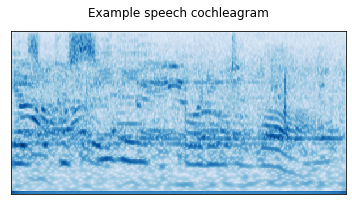

In [49]:
example_cochleagram = np.load('../demo_stim/example_cochleagram_0.npy', allow_pickle = True,) 
plot_cochleagram(example_cochleagram,'Example speech cochleagram' )

In [0]:
example_cochleagram= example_cochleagram.astype(float16)

In [87]:
labels = get_label(example_cochleagram )
print("Speech Example ... actual label: according ")


Predicted labels :
according; gain; above; fourteen; merger
Speech Example ... actual label: according 


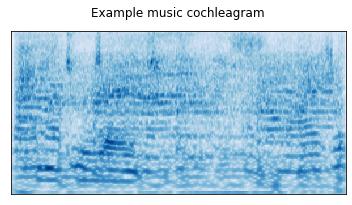

In [51]:
example_cochleagram_music = np.load('../demo_stim/example_cochleagram_1.npy', allow_pickle = True,) 
plot_cochleagram(example_cochleagram_music,'Example music cochleagram' )

In [94]:
labels = get_label(example_cochleagram_music, type = "music" )
print( "Music Example... actual label: "+ music_key[11].decode("utf-8"))

music
Predicted labels :
blues rock, hard rock; folk rock; 80s; punk, punk rock; disco
Music Example... actual label: blues rock, hard rock


In [138]:
word_key.shape

(589,)

In [115]:
# example 1:
sr, wav_f = wav.read('../demo_stim/example_10.wav') # note the sampling rate is 16000hz.
play_wav(wav_f, sr, 'Example ')

Example :


/content/pycochleagram/pycochleagram/cochleagram.py:135: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)


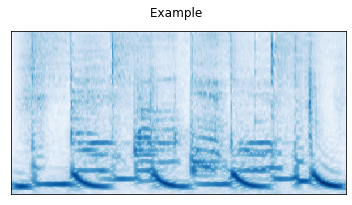

In [116]:
c_gram = generate_cochleagram(wav_f, sr, 'Example ')

In [117]:
labels = get_label(c_gram, type = "music")

Predicted labels :
chillout, downtempo; pop and chart; dance and electronica, electronica; hip hop, rnb and dance hall, hip hop, hip-hop, hiphop, rap; classical


In [135]:
get_exemples()

Speech Example 1... 
 clean speech, actual label: Increasingly
Speech Example 2... 
 background: speaker shaped noise, snr: -3db, actual label: Washington
Speech Example 3 ... 
 background: music, snr: 3db, actual label: Movies
Speech Example 4... 
 background: 2-spkr babble, snr: -6db, actual label: Equipment 
Speech Example 5... 
 background: Auditory scene, snr: -9db, actual label: Advantage 
Music Example 6... 
 Background: Auditory Scene, snr: -3db, actual label: pop rock

Music Example 7... 
 Background: Music-shaped noise, snr: -6db, actual label: post-rock, shoegaze, shoegazing

Music Example 8... 
 Background: 8-spkr babble, snr: 3db, actual label: soul, rnb

Music Example 9... 
 Background: 2-spkr babble, snr: 0db, actual label: big band, swing

Music Example 10... 
 Background: clean, actual label: chillout, downtempo

